## System 1: Homoclinic orbits

dx/dt = y

dy/dt = x-x^3

In [221]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [222]:
def func1(t,state):
    x, y = state
    dx_dt = y
    dy_dt = x-x**3
    velocity = np.array([dx_dt, dy_dt])
    return velocity

state_0 = np.array([1,1])
func1(1,state_0)

solution=solve_ivp(func1, (0,20), state_0, dense_output = True)


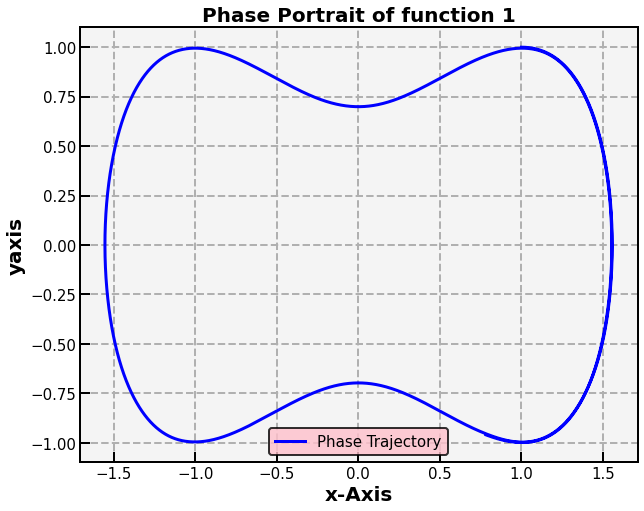

In [236]:
# Plot
fro, to = 0,10
tTrain = np.linspace(fro, to, 10000)
xTraindummy = solution.sol(tTrain)
xTrain = np.transpose(xTraindummy)

fig,axs = plt.subplots(figsize=(10,8))
axs.plot(xTrain[:,0],xTrain[:,1], "b-", linewidth=3, label ="Phase Trajectory")

axs.set_title("Phase Portrait of function 1", fontweight = "bold", fontsize=20)
axs.set_xlabel("x-Axis", fontweight= "bold", fontsize=20)
axs.set_ylabel("yaxis", fontweight="bold", fontsize=20)

axs.tick_params(direction="in", length =10, width=2, labelsize=15)

for spine in axs.spines.values():
    spine.set_linewidth(2)
    
legend = axs.legend(fontsize=15)
legend.get_frame().set_edgecolor("black")
legend.get_frame().set_linewidth(2)
legend.get_frame().set_facecolor("pink")
axs.set_facecolor("#f4f4f4")
axs.grid(True, linestyle = "--", linewidth=2)

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

import os
import argparse
import time

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=15)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [238]:
xTrain

array([[ 1.        ,  1.        ],
       [ 1.0010001 ,  0.999999  ],
       [ 1.0020002 ,  0.99999599],
       ...,
       [ 0.7840171 , -0.96010809],
       [ 0.78305715, -0.95980554],
       [ 0.78209749, -0.95950217]])

In [239]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.double)

In [240]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y_dummy = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=2)  # (T, M, D)
    temp= batch_y_dummy.squeeze(dim=1)
    batch_y=temp.unsqueeze(0)
    #batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [241]:
# Construct a neural network to approximate the dynamics of an ODE
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
func = ODEFunc().to(device)


In [242]:
solutions = []
temp1 = 0
for ic in batch_y0:
    sol = odeint(func, ic[0], batch_t[temp1])
    solutions.append(sol)
    temp1 = temp1+1
pred_toCalcLoss= torch.stack(solutions).unsqueeze(0)

In [243]:
pred_toCalcLoss-batch_y

tensor([[[[ 0.0000,  0.0000],
          [ 0.0019, -0.0005],
          [ 0.0038, -0.0011],
          [ 0.0057, -0.0016],
          [ 0.0076, -0.0021],
          [ 0.0095, -0.0027],
          [ 0.0115, -0.0032],
          [ 0.0134, -0.0038],
          [ 0.0153, -0.0043],
          [ 0.0172, -0.0049],
          [ 0.0191, -0.0054],
          [ 0.0210, -0.0060],
          [ 0.0229, -0.0066],
          [ 0.0248, -0.0071],
          [ 0.0267, -0.0077]],

         [[ 0.0000,  0.0000],
          [ 0.0003,  0.0042],
          [ 0.0006,  0.0084],
          [ 0.0009,  0.0126],
          [ 0.0013,  0.0168],
          [ 0.0016,  0.0210],
          [ 0.0019,  0.0252],
          [ 0.0023,  0.0294],
          [ 0.0026,  0.0335],
          [ 0.0030,  0.0377],
          [ 0.0034,  0.0418],
          [ 0.0038,  0.0460],
          [ 0.0042,  0.0501],
          [ 0.0046,  0.0542],
          [ 0.0050,  0.0583]],

         [[ 0.0000,  0.0000],
          [-0.0006,  0.0044],
          [-0.0013,  0.0088],
      

In [257]:
ii = 0
## Setting up the optimizer

# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(func.parameters(), lr=0.00001)

for itr in range(1, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(func, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions).unsqueeze(0)
        actual_toCalcLoss = batch_y
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                pred_toDisplay = pred_y.unsqueeze(1)
                actual_toDisplay = true_y
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0001 | Total Loss 1.932852
Iter 0020 | Total Loss 1.919700
Iter 0040 | Total Loss 1.921043
Iter 0060 | Total Loss 1.928490
Iter 0080 | Total Loss 1.929563
Iter 0100 | Total Loss 1.920488
Iter 0120 | Total Loss 1.921992
Iter 0140 | Total Loss 1.916358
Iter 0160 | Total Loss 1.914929
Iter 0180 | Total Loss 1.913121
Iter 0200 | Total Loss 1.913615
Iter 0220 | Total Loss 1.922085
Iter 0240 | Total Loss 1.920125
Iter 0260 | Total Loss 1.925615
Iter 0280 | Total Loss 1.925638
Iter 0300 | Total Loss 1.924173
Iter 0320 | Total Loss 1.921528
Iter 0340 | Total Loss 1.913359
Iter 0360 | Total Loss 1.918944
Iter 0380 | Total Loss 1.915641
Iter 0400 | Total Loss 1.922624
Iter 0420 | Total Loss 1.923849
Iter 0440 | Total Loss 1.923684
Iter 0460 | Total Loss 1.921174
Iter 0480 | Total Loss 1.917813
Iter 0500 | Total Loss 1.915639
Iter 0520 | Total Loss 1.919777
Iter 0540 | Total Loss 1.916132
Iter 0560 | Total Loss 1.914895
Iter 0580 | Total Loss 1.923761
Iter 0600 | Total Loss 1.920409
Iter 062

In [253]:
model = func
#modelVar = funcVariance
# modelSkw = funcSkewness
# modelKurt = funcKurtosis


model.eval()
# modelVar.eval()
# modelSkw.eval()
# modelKurt.eval()


# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    reconstruction = odeint(func,y0 , t).to(device)

y0_prediction = reconstruction[-1,:]
tCheck = np.linspace(to,to+1,1000)
xCheckdummy = solution.sol(tCheck)
xCheck = np.transpose(xCheckdummy)

tCheck_nn = torch.from_numpy(tCheck).to(dtype=torch.double)
with torch.no_grad():
    predicted_states = odeint(func,y0_prediction , tCheck_nn).to(device)

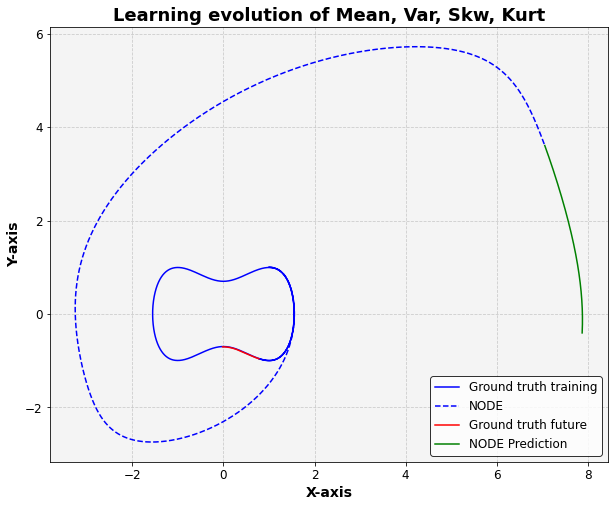

In [254]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(xTrain[:,0],xTrain[:,1], 'b',label='Ground truth training')
plt.plot(reconstruction[:,0],reconstruction[:,1], 'b--',label='NODE')
plt.plot(xCheck[:,0],xCheck[:,1], 'r',label='Ground truth future')
plt.plot(predicted_states[:,0],predicted_states[:,1], 'g-',label='NODE Prediction')


ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

#plt.savefig('plot3_Mean_all_parts.pdf', bbox_inches='tight')

# Show the plot
plt.show()
